In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
from conditionalconformal import CondConf
import itertools
import math

/u/local/apps/python/3.9.6/gcc-4.8.5/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

np.random.seed(1)
random.seed(1)

dimension_z = 100
dimension_x = 100
number_z = 30
# Generating 30 vectors, each with 100 dimensions
z_domain = np.random.normal(size=(number_z, dimension_z))

# Generating beta_1 and beta_2
beta_1 = np.random.uniform(-1, 1, dimension_x)
beta_2 = np.random.uniform(-1, 1, dimension_z)


In [3]:

def generate_function(beta_1, beta_2):


    def function_1(X, Z):
        epsilon = truncnorm.rvs(-1, 1)  # Generate epsilon from a truncated normal distribution
        T = (np.dot(beta_1.T, X) ** 2) * (np.sin(np.dot(beta_2.T, Z)) ** 2) + 1 + epsilon
        return T

    return function_1

function_1 = generate_function(beta_1, beta_2)

In [4]:
def prepare_data_for_regression(df):
    # Extracting X and Z and converting them into suitable format for regression
    X_data = np.array(df['X'].tolist())
    Z_data = np.array(df['Z'].tolist())

    # Concatenating X and Z
    combined_data = np.concatenate([X_data, Z_data], axis=1)

    return combined_data


In [5]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,dimension_x:(dimension_x+dimension_z)])#len 500

    # Initialize the indicator matrix
    matrix = np.zeros((len(np.array(feature[:,1])), number_z))

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0, number_z):
            if  np.array_equal(value, z_domain[j]):
                matrix[i, j] = 1

    return matrix

In [6]:
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

def conformal_predict_z_0(alpha=0.1, m=100, Z_new=Z_new, N=1000, t=200):
    IR = []
    for j in range(t):
        data_points = []
        for _ in range(N):
            # Randomly select a vector from z_domain to be Z
            Z = z_domain[np.random.randint(z_domain.shape[0])]

            # Compute the mean of the square of Z
            mean_x = np.mean(Z**2)

            # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
            X = np.random.normal(mean_x, 1, dimension_x)

            # Compute T_1 and T_2 using the generated functions
            T_1 = function_1(X, Z)
            #T_2 = function_2(X, Z)

            # Append the data point (X, Z, T_1, T_2) to the list
            data_points.append([X, Z, T_1])
        # Split the data into D_cali and D_train
        D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
        D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

        # Preparing data for regression
        X_train = prepare_data_for_regression(D_train)
        # Extracting T_1
        T_1_train = D_train['T_1']
        # Using a polynomial model (Let's start with a 2nd degree polynomial)
        poly = PolynomialFeatures(degree=2)
        X_train_poly = poly.fit_transform(X_train)
        # Training the model
        model = LinearRegression()
        model.fit(X_train_poly, T_1_train)

        score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))
        
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())
        
        data_points_new = []
        for _ in range(m):
            # Compute the mean of the square of Z
            mean_x_new = np.mean(Z_new**2)
            # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
            X_new = np.random.normal(mean_x_new, 1, dimension_x)
            # Compute T_1 and T_2 using the generated functions
            T_1_new = function_1(X_new, Z_new)
            #T_2_new = function_2(X_new, Z_new)

            # Append the data point (X, Z, T_1, T_2) to the list
            data_points_new.append([X_new, Z_new, T_1_new])

        # Split the data into D_cali and D_train
        D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])
        
        X_neww = prepare_data_for_regression(D_new)
        T_1_new= D_new['T_1']
        X_new_poly = poly.transform(X_neww)
        T_1_pred_new = model.predict(X_new_poly)

        Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
        
        # Calculate intervals
        hat_t_L = T_1_pred_new - d
        hat_t_U = T_1_pred_new + d 
        IR.append(np.mean((hat_t_L <= T_1_new) & (T_1_new <= hat_t_U)))
        

            
    return IR, d

(array([0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

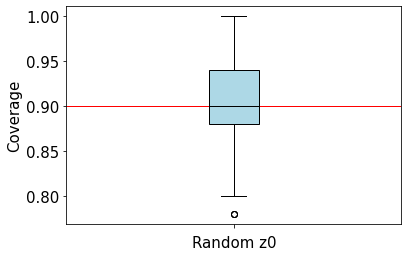

In [7]:
import time

np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

IR, d = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=10000, t=200)

###
plt.boxplot(IR, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='lightblue'))
plt.yticks( fontsize=10)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=1)
plt.xlabel('Random z0', fontsize=15)
plt.ylabel('Coverage', fontsize=15)
plt.yticks( fontsize=15)


In [6]:
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new, N = 1000):
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X = np.random.normal(mean_x, 1, dimension_x)

        # Compute T_1 and T_2 using the generated functions
        T_1 = function_1(X, Z)
        #T_2 = function_2(X, Z)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

    # Preparing data for regression
    X_train = prepare_data_for_regression(D_train)
    # Extracting T_1
    T_1_train = D_train['T_1']
    # Using a polynomial model (Let's start with a 2nd degree polynomial)
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    # Training the model
    model = LinearRegression()
    model.fit(X_train_poly, T_1_train)

    score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))

    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, 1, dimension_x)
        # Compute T_1 and T_2 using the generated functions
        T_1_new = function_1(X_new, Z_new)
        #T_2_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = prepare_data_for_regression(D_new)
    T_1_new= D_new['T_1']
    X_new_poly = poly.transform(X_neww)
    T_1_pred_new = model.predict(X_new_poly)

    Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) > reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [7]:

np.random.seed(1)
random.seed(1)
m_0 = 50
IR_compare = []

Z_new = z_domain[np.random.randint(z_domain.shape[0])]

for i in range(200):
    result = conformal_predict(alpha=0.1, m=m_0,  Z_new=Z_new, N = 10000)
    IR_compare.append(result[2]) #IR_compare_100_100

   

(-5.0, 50.0)

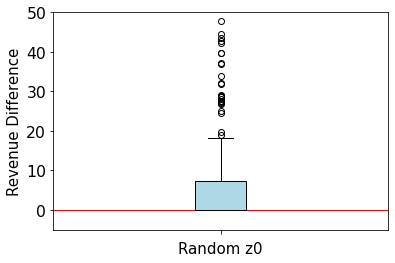

In [9]:


###
plt.boxplot(IR_compare, patch_artist=True, boxprops=dict(facecolor='lightblue'),  # Box color set to blue
            medianprops=dict(color="black"))
plt.xlabel('Random z0', fontsize=15)
plt.ylabel('Revenue Difference', fontsize=15)
plt.yticks( fontsize=15.603240200456185)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0, color='red', linestyle='-', label='', linewidth=1)
plt.ylim(-5,50)

In [10]:
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new):
   

    score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))

    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, 1, dimension_x)
        # Compute T_1 and T_2 using the generated functions
        T_1_new = function_1(X_new, Z_new)
        #T_2_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = prepare_data_for_regression(D_new)
    T_1_new= D_new['T_1']
    X_new_poly = poly.transform(X_neww)
    T_1_pred_new = model.predict(X_new_poly)

    Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) > reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [11]:

np.random.seed(1)
random.seed(1)
# 设置 N 的不同值
N_values = [1000, 3000, 5000, 7000, 9000, 11000, 13000]
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 500

# 初始化用于存储结果的字典
results = {"payment": [], "sb_value": [], "max_welfare": []}

# 对于每个 N 值，运行函数 500次并计算平均值
for N in N_values:
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X = np.random.normal(mean_x, 1, dimension_x)

        # Compute T_1 and T_2 using the generated functions
        T_1 = function_1(X, Z)
        #T_2 = function_2(X, Z)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

    # Preparing data for regression
    X_train = prepare_data_for_regression(D_train)
    # Extracting T_1
    T_1_train = D_train['T_1']
    # Using a polynomial model (Let's start with a 2nd degree polynomial)
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    # Training the model
    model = LinearRegression()
    model.fit(X_train_poly, T_1_train)
    
    payments, sb_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, sb_value, max_welfare = conformal_predict(0.1, 50, Z_new)
        payments.append(payment)
        sb_values.append(sb_value)
        max_welfares.append(max_welfare)
    results["payment"].append(np.mean(payments))
    results["sb_value"].append(np.mean(sb_values))
    results["max_welfare"].append(np.mean(max_welfares))


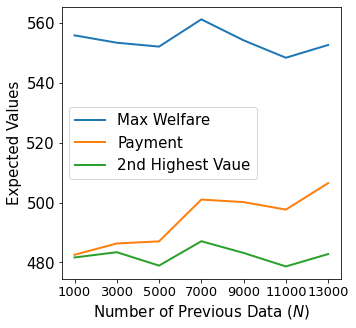

In [24]:
###
plt.figure(figsize=(5,5))  # 修改此处以创建正方形的图形
plt.plot(N_values[0:7], results["max_welfare"][0:7], label="Max Welfare", linewidth=2)  # 加粗线条
plt.plot(N_values[0:7], results["payment"][0:7], label="Payment", linewidth=2)  # 加粗线条
plt.plot(N_values[0:7], results["sb_value"][0:7], label="2nd Highest Vaue", linewidth=2)  # 加粗线条


# 设置坐标轴标签和字体大小
plt.xlabel("Number of Previous Data ($N$)", fontsize=15)
plt.ylabel("Expected Values", fontsize=15)

# 设置图例和字体大小,bbox_to_anchor=(0.38, 0.5),
plt.legend(fontsize=15,  loc='center left')

# 设置横坐标为对数尺度，并确保刻度清晰
#plt.xscale("log")

# 设置刻度标签的字体大小
plt.xticks(N_values[0:7], labels=[str(N) for N in N_values[0:7]], fontsize=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=13)
plt.show()

In [14]:
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
data_points = []
N = 20000
for _ in range(N):
    # Randomly select a vector from z_domain to be Z
    Z = z_domain[np.random.randint(z_domain.shape[0])]

    # Compute the mean of the square of Z
    mean_x = np.mean(Z**2)

    # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
    X = np.random.normal(mean_x, 1, dimension_x)

    # Compute T_1 and T_2 using the generated functions
    T_1 = function_1(X, Z)
    #T_2 = function_2(X, Z)

    # Append the data point (X, Z, T_1, T_2) to the list
    data_points.append([X, Z, T_1])
# Split the data into D_cali and D_train
D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

# Preparing data for regression
X_train = prepare_data_for_regression(D_train)
# Extracting T_1
T_1_train = D_train['T_1']
# Using a polynomial model (Let's start with a 2nd degree polynomial)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
# Training the model
model = LinearRegression()
model.fit(X_train_poly, T_1_train)
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new):
   

    score_fn = lambda feature,  y : abs(y - model.predict(poly.transform(pd.DataFrame(feature))))

    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(prepare_data_for_regression(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 150-dimensional vector X from a normal distribution with mean mean_x and variance 1
        X_new = np.random.normal(mean_x_new, 1, dimension_x)
        # Compute T_1 and T_2 using the generated functions
        T_1_new = function_1(X_new, Z_new)
        #T_2_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1, T_2) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = prepare_data_for_regression(D_new)
    T_1_new= D_new['T_1']
    X_new_poly = poly.transform(X_neww)
    T_1_pred_new = model.predict(X_new_poly)

    Xtest = np.array([prepare_data_for_regression(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x) 
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) > reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [15]:

# 设置 m 的不同值
m_values = list(range(50, 301, 50))
np.random.seed(1)
random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 300

# 初始化用于存储结果的字典
results_m = {"payment": [], "y_value": [], "max_welfare": []}

# 对于每个 m 值，运行函数 100 次并计算平均值
for m in m_values:
    payments, y_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, y_value, max_welfare = conformal_predict(0.1, m, Z_new)
        payments.append(payment)
        y_values.append(y_value)
        max_welfares.append(max_welfare)
    results_m["payment"].append(np.mean(payments))
    results_m["y_value"].append(np.mean(y_values))
    results_m["max_welfare"].append(np.mean(max_welfares))
    


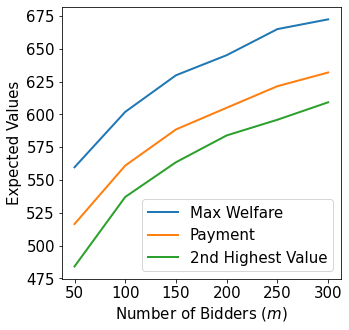

In [25]:
###
# 绘制结果图
plt.figure(figsize=(5, 5))
plt.plot(m_values, results_m["max_welfare"], label="Max Welfare", linewidth=2)
plt.plot(m_values, results_m["payment"], label="Payment", linewidth=2)
plt.plot(m_values, results_m["y_value"], label="2nd Highest Value", linewidth=2)

plt.xlabel("Number of Bidders $(m)$", fontsize=15)
plt.ylabel("Expected Values", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title("")#Average Payment, 2nd Best Price, and Max Welfare for Different m Values
# 设置图例和字体大小, bbox_to_anchor=(0.0, 1), loc='upper left'
plt.legend(fontsize=15)
plt.show()